# TP 5b (optionnel) : Détection de visages avec les classifieurs Haar Cascade

Enseignant : Jean Delpech

Cours : Data Science

Classe : M1 Data/IA

Année scolaire : 2025/2026

Dernière mise à jour : janvier 2026

## Module Data Science M1 - Séances 11 & 12

**Objectifs du TP :**

Ce TP est optionnel. Il est assez technique, l’objectif est de vous montrer ce que l’on peut faire avec la bibliothèque OpenCV et des algorithmes d’apprentissages relativement sobres, sans prétendre vous les enseigner dans les détails. Il s’agit plus d’une familiarisation. Il est attendu que les étudiants qui se lanceront dans ce TP en autonomie auront déjà bien assimilé les concepts vus en cours et n’hésiterons pas à faire leurs propres recherches pour éclaircir tel ou tel point : ce TP est une « récréation », un point de départ si le sujet du traitement d’image vous passionne.

La première partie (section 1 à 8) est constituée de code déjà écrit, exécutez les cellules afin de comprendre ce que chaque méthode fait, quels sont les effets de chaque paramètres, etc. Le notebook déroule une exploration du dataset en testant différents paramètes, différents types de classifieurs afin de vous familiariser avec la problématique, voir ce qui fonctionne, ce qui ne fonctionne pas, etc.

Suivent des exercices pratiques à partir de la section 9 (améliorer la détection de visage).

Ce TP vous permettra de :

- Comprendre le principe des classifieurs en cascade (Haar Cascades)
- Utiliser les détecteurs pré-entraînés d'OpenCV
- Implémenter une détection hiérarchique (visages → yeux)
- Évaluer les performances d'un système de détection
- Optimiser les paramètres pour réduire les faux positifs/négatifs

Nous travaillerons avec le dataset **Labeled Faces in the Wild (LFW)** disponible via scikit-learn.

## Ressources

- **Documentation OpenCV** : https://docs.opencv.org/4.x/d7/d8b/tutorial_py_face_detection.html
- **Dataset LFW** : http://vis-www.cs.umass.edu/lfw/
- **Article original Viola-Jones** : "Rapid Object Detection using a Boosted Cascade of Simple Features" (2001)


## 1. Introduction théorique

### 1.1 Les classifieurs Haar Cascade

Les **Haar Cascades** sont une méthode de détection d'objets proposée par Viola et Jones en 2001. Cette méthode est particulièrement efficace pour la détection de visages en temps réel.

**Principe :**

1. **Caractéristiques de Haar** : Filtres rectangulaires qui capturent les contrastes locaux (ex: les yeux sont plus sombres que les joues)

2. **Image intégrale** : Permet de calculer très rapidement la somme des pixels dans n'importe quel rectangle

3. **AdaBoost** : Algorithme d'apprentissage qui sélectionne les caractéristiques les plus discriminantes

4. **Cascade de classifieurs** : Série de classifieurs de complexité croissante. Une région est rejetée dès qu'elle échoue à un étage, ce qui accélère considérablement la détection.

### 1.2 Avantages et limites

**Avantages :**
- Très rapide (temps réel possible)
- Fonctionne bien pour les visages frontaux
- Pas besoin de GPU

**Limites :**
- Sensible à l'orientation (visages de profil mal détectés)
- Peut générer des faux positifs
- Moins précis que les méthodes deep learning modernes

## 2. Installation et imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
from sklearn.datasets import fetch_lfw_people

print(f"OpenCV version : {cv2.__version__}")

# Vérification de la disponibilité des classifieurs Haar
haar_path = cv2.data.haarcascades
print(f"Chemin des classifieurs Haar : {haar_path}")
print(f"Fichiers disponibles : {os.listdir(haar_path)[:5]}...")

OpenCV version : 4.12.0
Chemin des classifieurs Haar : /home/jean/.venv/DataScience/lib/python3.11/site-packages/cv2/data/
Fichiers disponibles : ['haarcascade_eye.xml', 'haarcascade_frontalface_default.xml', 'haarcascade_frontalface_alt2.xml', 'haarcascade_license_plate_rus_16stages.xml', 'haarcascade_frontalface_alt.xml']...


### 2.1 Fonctions utilitaires

In [2]:
def afficher_images(images, titres=None, n_cols=5, figsize=(15, 10), cmap='gray'):
    """
    Affiche une grille d'images.
    
    Paramètres
    ----------
    images : list
        Liste des images à afficher
    titres : list, optional
        Liste des titres
    n_cols : int
        Nombre de colonnes
    """
    n_images = len(images)
    n_rows = (n_images + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.array(axes).flatten()
    
    for i, ax in enumerate(axes):
        if i < n_images:
            img = images[i]
            if len(img.shape) == 3:
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                ax.imshow(img, cmap=cmap)
            if titres and i < len(titres):
                ax.set_title(titres[i], fontsize=9)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


def dessiner_rectangles(image, rectangles, couleur=(0, 255, 0), epaisseur=2):
    """
    Dessine des rectangles sur une image.
    
    Paramètres
    ----------
    image : ndarray
        Image source
    rectangles : list
        Liste de rectangles (x, y, w, h)
    couleur : tuple
        Couleur BGR
    epaisseur : int
        Épaisseur du trait
    
    Retourne
    --------
    ndarray : Image avec rectangles
    """
    img_copie = image.copy()
    if len(img_copie.shape) == 2:
        img_copie = cv2.cvtColor(img_copie, cv2.COLOR_GRAY2BGR)
    
    for (x, y, w, h) in rectangles:
        cv2.rectangle(img_copie, (x, y), (x + w, y + h), couleur, epaisseur)
    
    return img_copie

---

## 3. Chargement du dataset LFW

Le dataset **Labeled Faces in the Wild (LFW)** contient plus de 13 000 images de visages collectées sur le web. C'est un dataset de référence pour l'évaluation des algorithmes de reconnaissance faciale.

In [3]:
# Chargement du dataset LFW
# min_faces_per_person=20 : garde uniquement les personnes avec au moins 20 photos
# resize=1.0 : garde la taille originale (62x47 pixels par défaut avec resize=0.5)

print("Chargement du dataset LFW (peut prendre quelques minutes la première fois)...")
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=1.0)

# Informations sur le dataset
n_samples, h, w = lfw_people.images.shape
X = lfw_people.images  # Images en niveaux de gris
y = lfw_people.target  # Labels (identité de la personne)
target_names = lfw_people.target_names  # Noms des personnes

print(f"\nDataset chargé !")
print(f"Nombre d'images : {n_samples}")
print(f"Taille des images : {h} x {w}")
print(f"Nombre de personnes : {len(target_names)}")
print(f"\nPersonnes dans le dataset :")
for i, name in enumerate(target_names[:10]):
    n_images = np.sum(y == i)
    print(f"  - {name} : {n_images} images")
if len(target_names) > 10:
    print(f"  ... et {len(target_names) - 10} autres personnes")

Chargement du dataset LFW (peut prendre quelques minutes la première fois)...

Dataset chargé !
Nombre d'images : 3023
Taille des images : 125 x 94
Nombre de personnes : 62

Personnes dans le dataset :
  - Alejandro Toledo : 39 images
  - Alvaro Uribe : 35 images
  - Amelie Mauresmo : 21 images
  - Andre Agassi : 36 images
  - Angelina Jolie : 20 images
  - Ariel Sharon : 77 images
  - Arnold Schwarzenegger : 42 images
  - Atal Bihari Vajpayee : 24 images
  - Bill Clinton : 29 images
  - Carlos Menem : 21 images
  ... et 52 autres personnes


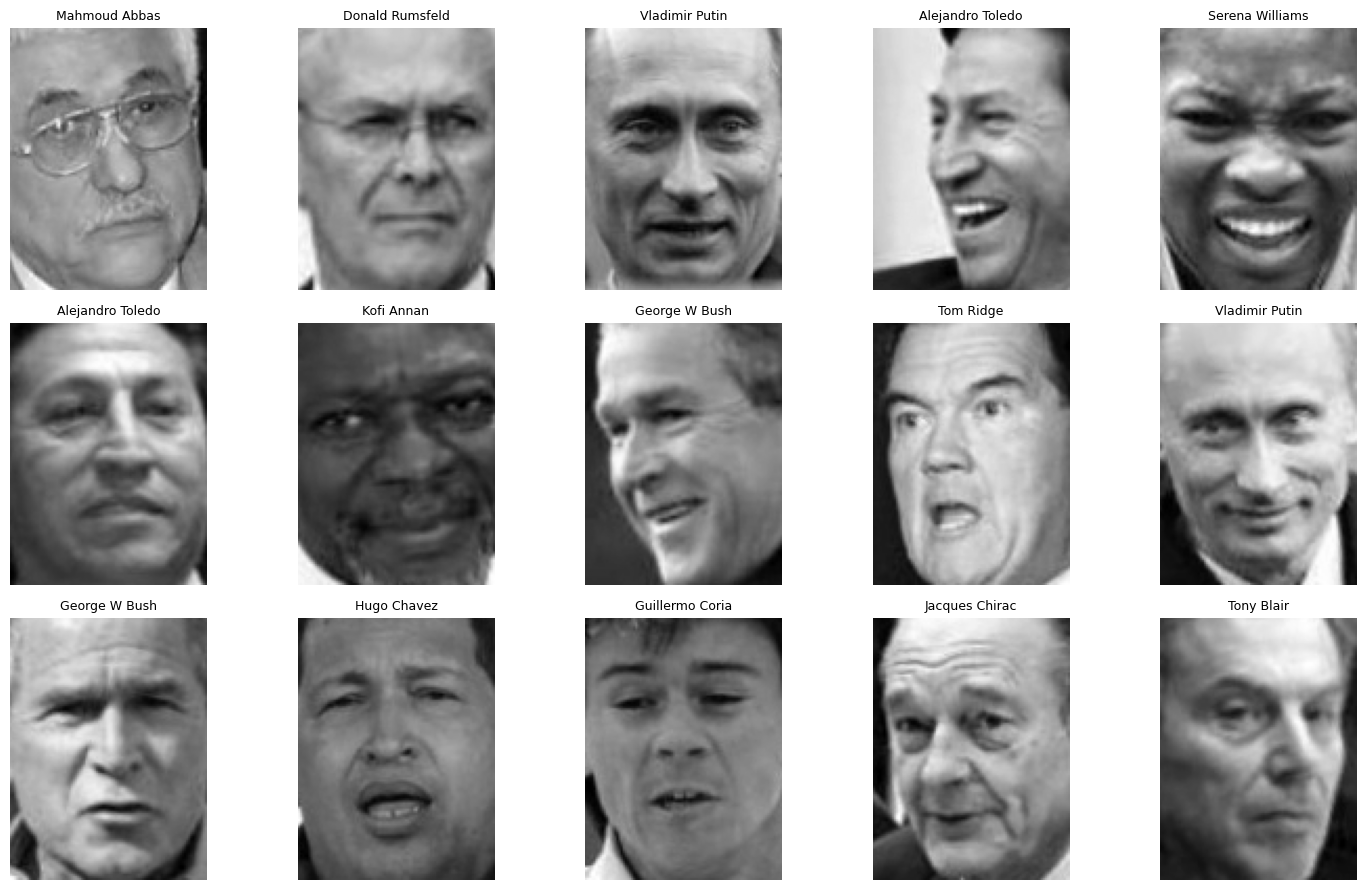

In [4]:
# Visualisation de quelques images
indices = np.random.choice(n_samples, 15, replace=False)
images_sample = [X[i] for i in indices]
titres_sample = [target_names[y[i]] for i in indices]

afficher_images(images_sample, titres_sample, n_cols=5, figsize=(15, 9))

### 3.1 Préparation des images pour OpenCV

Les images LFW sont en float64 [0, 1]. OpenCV attend des images uint8 [0, 255].

In [5]:
def preparer_image_opencv(image):
    """
    Convertit une image LFW (float [0,1]) en format OpenCV (uint8 [0,255]).
    """
    # Normalisation si nécessaire
    if image.max() <= 1.0:
        image = image * 255
    return image.astype(np.uint8)

# Conversion de tout le dataset
X_cv = np.array([preparer_image_opencv(img) for img in X])

print(f"Format original : {X[0].dtype}, min={X[0].min():.2f}, max={X[0].max():.2f}")
print(f"Format OpenCV : {X_cv[0].dtype}, min={X_cv[0].min()}, max={X_cv[0].max()}")

Format original : float32, min=0.03, max=0.97
Format OpenCV : uint8, min=7, max=246


## 4. Chargement des classifieurs Haar Cascade

OpenCV fournit plusieurs classifieurs pré-entraînés pour différents types d'objets.

In [6]:
# Chargement des classifieurs
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_cascade_alt = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
face_cascade_alt2 = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
eye_glasses_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml')
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

# Vérification du chargement
print("Classifieurs chargés :")
print(f"  - Face (default) : {'OK' if not face_cascade.empty() else 'ERREUR'}")
print(f"  - Face (alt) : {'OK' if not face_cascade_alt.empty() else 'ERREUR'}")
print(f"  - Face (alt2) : {'OK' if not face_cascade_alt2.empty() else 'ERREUR'}")
print(f"  - Eye : {'OK' if not eye_cascade.empty() else 'ERREUR'}")
print(f"  - Eye (glasses) : {'OK' if not eye_glasses_cascade.empty() else 'ERREUR'}")
print(f"  - Smile : {'OK' if not smile_cascade.empty() else 'ERREUR'}")

Classifieurs chargés :
  - Face (default) : OK
  - Face (alt) : OK
  - Face (alt2) : OK
  - Eye : OK
  - Eye (glasses) : OK
  - Smile : OK


## 5. Détection de visages

### 5.1 La fonction detectMultiScale

La fonction principale pour la détection est `detectMultiScale()` :

```python
faces = cascade.detectMultiScale(
    image,           # Image en niveaux de gris
    scaleFactor,     # Facteur de réduction entre chaque échelle (ex: 1.1)
    minNeighbors,    # Nombre minimum de voisins pour valider une détection
    minSize,         # Taille minimum de l'objet (largeur, hauteur)
    maxSize          # Taille maximum de l'objet
)
```

**Paramètres importants :**

- `scaleFactor` : Plus proche de 1.0 = plus précis mais plus lent. Typiquement 1.05 à 1.3
- `minNeighbors` : Plus élevé = moins de faux positifs mais risque de manquer des visages. Typiquement 3 à 6

In [7]:
def detecter_visages(image, cascade=None, scale_factor=1.1, min_neighbors=5, min_size=(20, 20)):
    """
    Détecte les visages dans une image.
    
    Paramètres
    ----------
    image : ndarray
        Image en niveaux de gris (uint8)
    cascade : CascadeClassifier
        Classifieur à utiliser
    scale_factor : float
        Facteur d'échelle
    min_neighbors : int
        Nombre minimum de voisins
    min_size : tuple
        Taille minimum du visage
    
    Retourne
    --------
    list : Liste de rectangles (x, y, w, h)
    """
    if cascade is None:
        cascade = face_cascade
    
    faces = cascade.detectMultiScale(
        image,
        scaleFactor=scale_factor,
        minNeighbors=min_neighbors,
        minSize=min_size
    )
    
    return faces

### 5.2 Premier test sur quelques images

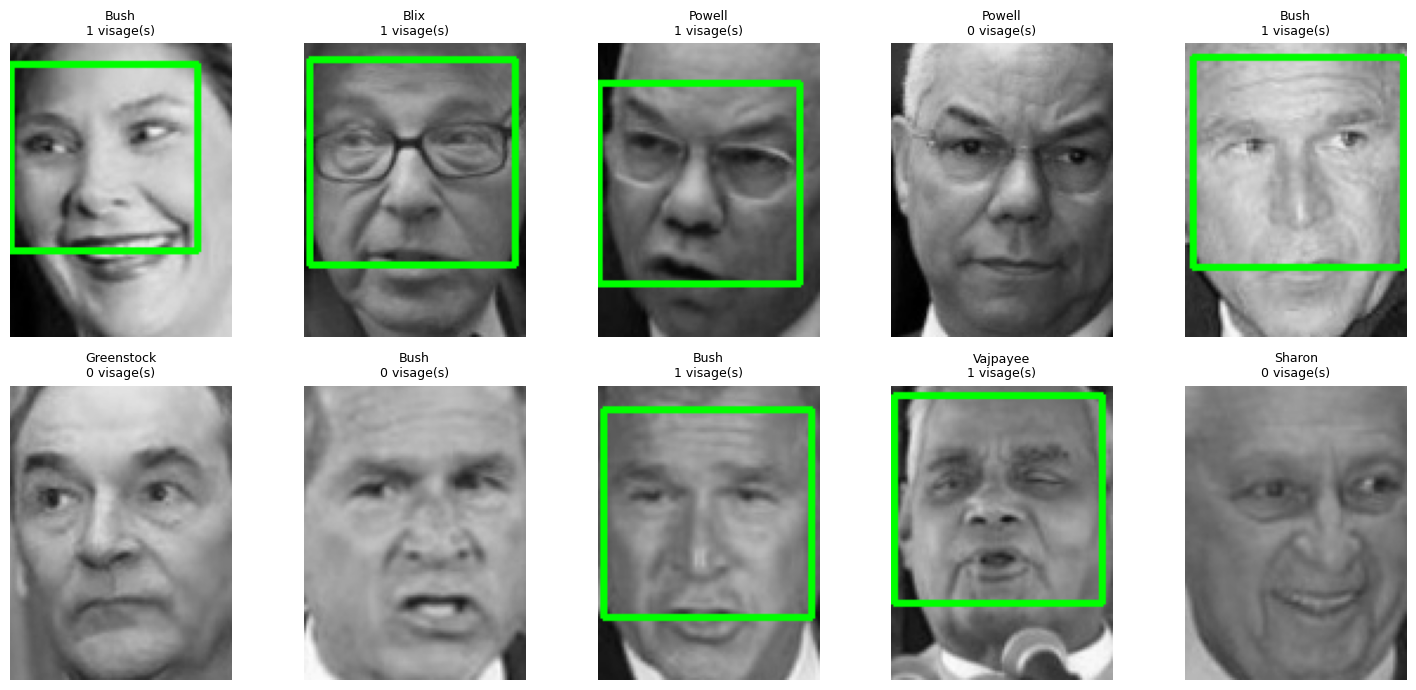

In [8]:
# Test sur 10 images aléatoires
np.random.seed(42)
indices_test = np.random.choice(n_samples, 10, replace=False)

resultats = []
titres = []

for idx in indices_test:
    img = X_cv[idx]
    faces = detecter_visages(img, min_neighbors=3, min_size=(15, 15))
    
    img_result = dessiner_rectangles(img, faces, couleur=(0, 255, 0))
    resultats.append(img_result)
    
    n_faces = len(faces)
    titres.append(f"{target_names[y[idx]].split()[-1]}\n{n_faces} visage(s)")

afficher_images(resultats, titres, n_cols=5, figsize=(15, 7))

### 5.3 Influence des paramètres

Voyons comment les paramètres affectent la détection.

Effet du paramètre minNeighbors :
- Valeur faible → plus de détections (mais plus de faux positifs)
- Valeur élevée → moins de détections (mais plus de faux négatifs)


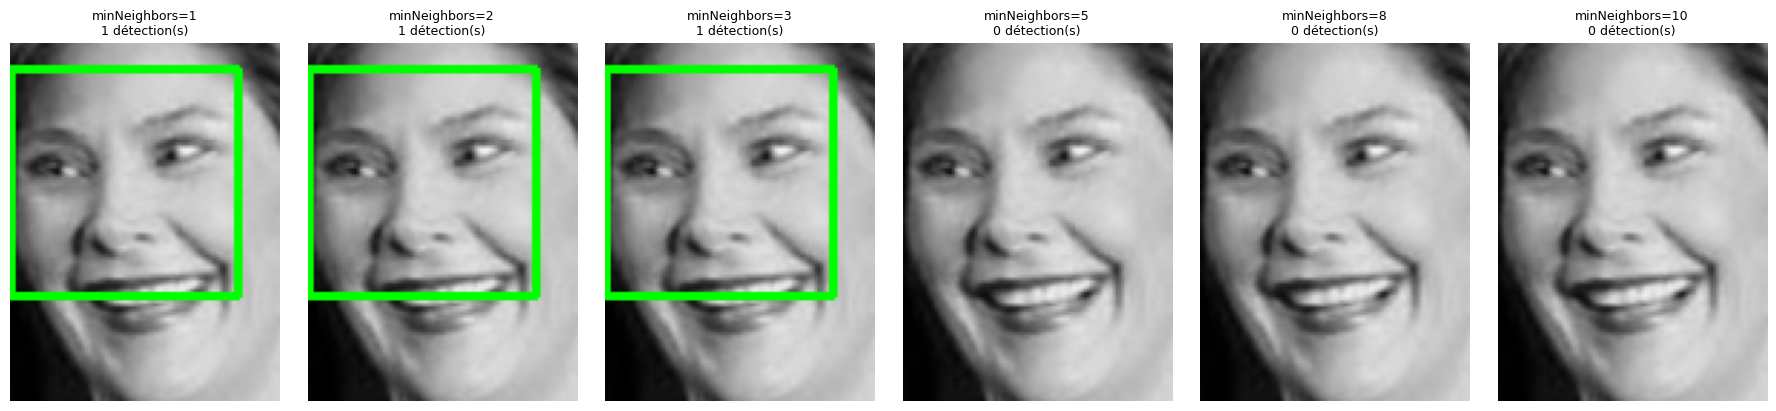

In [9]:
# Sélection d'une image test
idx_demo = indices_test[0]
img_demo = X_cv[idx_demo]

# Test avec différentes valeurs de minNeighbors
min_neighbors_values = [1, 2, 3, 5, 8, 10]

resultats_mn = []
titres_mn = []

for mn in min_neighbors_values:
    faces = detecter_visages(img_demo, min_neighbors=mn, min_size=(15, 15))
    img_result = dessiner_rectangles(img_demo, faces)
    resultats_mn.append(img_result)
    titres_mn.append(f"minNeighbors={mn}\n{len(faces)} détection(s)")

print("Effet du paramètre minNeighbors :")
print("- Valeur faible → plus de détections (mais plus de faux positifs)")
print("- Valeur élevée → moins de détections (mais plus de faux négatifs)")

afficher_images(resultats_mn, titres_mn, n_cols=6, figsize=(18, 4))

Effet du paramètre scaleFactor :
- Valeur proche de 1.0 → plus précis mais plus lent
- Valeur élevée → plus rapide mais moins précis


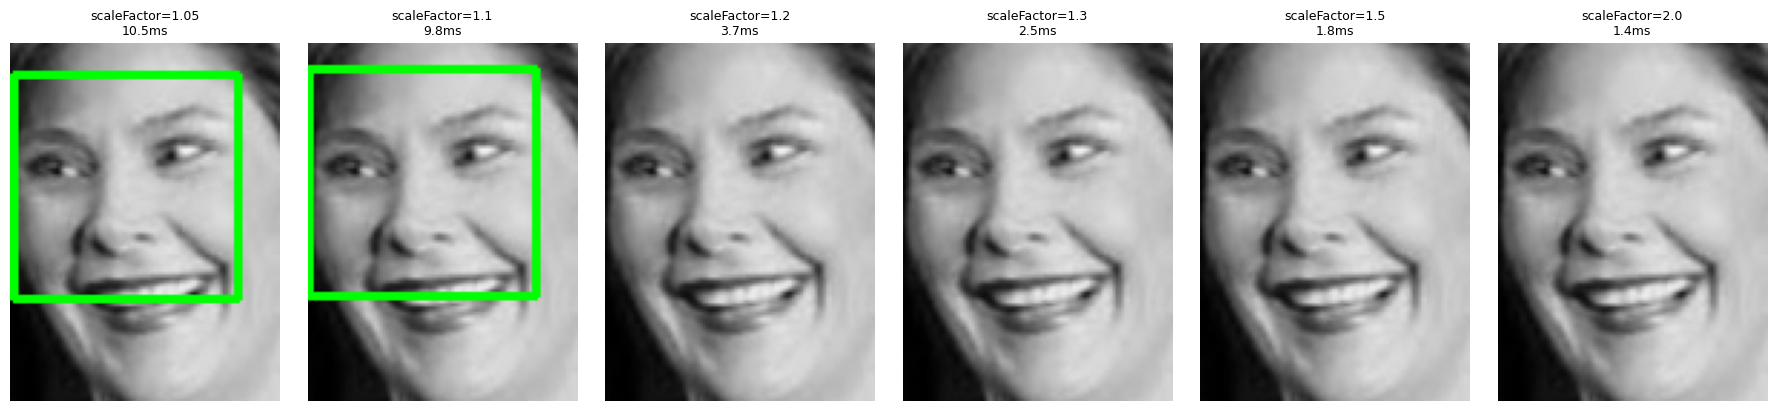

In [10]:
# Test avec différentes valeurs de scaleFactor
scale_factors = [1.05, 1.1, 1.2, 1.3, 1.5, 2.0]

resultats_sf = []
titres_sf = []
temps_sf = []

for sf in scale_factors:
    start = time.perf_counter()
    faces = detecter_visages(img_demo, scale_factor=sf, min_neighbors=3, min_size=(15, 15))
    elapsed = (time.perf_counter() - start) * 1000
    
    img_result = dessiner_rectangles(img_demo, faces)
    resultats_sf.append(img_result)
    titres_sf.append(f"scaleFactor={sf}\n{elapsed:.1f}ms")
    temps_sf.append(elapsed)

print("Effet du paramètre scaleFactor :")
print("- Valeur proche de 1.0 → plus précis mais plus lent")
print("- Valeur élevée → plus rapide mais moins précis")

afficher_images(resultats_sf, titres_sf, n_cols=6, figsize=(18, 4))

## 6. Évaluation sur le dataset LFW

Puisque les images LFW contiennent chacune exactement un visage (centré), nous pouvons évaluer le taux de détection.

In [13]:
def evaluer_detecteur(images, cascade, scale_factor=1.1, min_neighbors=5, min_size=(15, 15)):
    """
    Évalue un détecteur sur un ensemble d'images.
    
    Pour LFW, chaque image contient exactement 1 visage.
    - Vrai positif (TP) : 1 visage détecté
    - Faux négatif (FN) : 0 visage détecté
    - Faux positif (FP) : >1 visages détectés
    
    Retourne
    --------
    dict : Statistiques de détection
    """
    stats = {
        'total': len(images),
        'tp': 0,  # Exactement 1 visage détecté
        'fn': 0,  # Aucun visage détecté
        'fp': 0,  # Plus d'un visage détecté
        'temps_total': 0
    }
    
    for img in images:
        start = time.perf_counter()
        faces = cascade.detectMultiScale(
            img,
            scaleFactor=scale_factor,
            minNeighbors=min_neighbors,
            minSize=min_size
        )
        stats['temps_total'] += time.perf_counter() - start
        
        n_faces = len(faces)
        if n_faces == 1:
            stats['tp'] += 1
        elif n_faces == 0:
            stats['fn'] += 1
        else:
            stats['fp'] += 1
    
    # Calcul des métriques
    stats['taux_detection'] = stats['tp'] / stats['total'] * 100
    stats['taux_faux_negatifs'] = stats['fn'] / stats['total'] * 100
    stats['taux_faux_positifs'] = stats['fp'] / stats['total'] * 100
    stats['temps_moyen_ms'] = stats['temps_total'] / stats['total'] * 1000
    
    return stats


def afficher_stats(stats, titre=""):
    """Affiche les statistiques de détection."""
    print(f"\n{'=' * 50}")
    print(f"{titre}")
    print(f"{'=' * 50}")
    print(f"Images testées : {stats['total']}")
    print(f"\nRésultats :")
    print(f"  Détections correctes (1 visage) : {stats['tp']} ({stats['taux_detection']:.1f}%)")
    print(f"  Faux négatifs (0 visage) : {stats['fn']} ({stats['taux_faux_negatifs']:.1f}%)")
    print(f"  Faux positifs (>1 visage) : {stats['fp']} ({stats['taux_faux_positifs']:.1f}%)")
    print(f"\nTemps moyen par image : {stats['temps_moyen_ms']:.2f} ms")

In [14]:
# Évaluation sur un échantillon (pour gagner du temps)
n_eval = min(500, n_samples)
indices_eval = np.random.choice(n_samples, n_eval, replace=False)
X_eval = X_cv[indices_eval]

print(f"Évaluation sur {n_eval} images...")

# Test avec paramètres par défaut
stats_default = evaluer_detecteur(
    X_eval, 
    face_cascade, 
    scale_factor=1.1, 
    min_neighbors=5,
    min_size=(15, 15)
)
afficher_stats(stats_default, "Paramètres par défaut (scaleFactor=1.1, minNeighbors=5)")

Évaluation sur 500 images...

Paramètres par défaut (scaleFactor=1.1, minNeighbors=5)
Images testées : 500

Résultats :
  Détections correctes (1 visage) : 154 (30.8%)
  Faux négatifs (0 visage) : 344 (68.8%)
  Faux positifs (>1 visage) : 2 (0.4%)

Temps moyen par image : 5.56 ms


In [15]:
# Test avec paramètres optimisés pour réduire les faux négatifs
stats_sensible = evaluer_detecteur(
    X_eval, 
    face_cascade, 
    scale_factor=1.05, 
    min_neighbors=3,
    min_size=(10, 10)
)
afficher_stats(stats_sensible, "Paramètres sensibles (scaleFactor=1.05, minNeighbors=3)")


Paramètres sensibles (scaleFactor=1.05, minNeighbors=3)
Images testées : 500

Résultats :
  Détections correctes (1 visage) : 265 (53.0%)
  Faux négatifs (0 visage) : 223 (44.6%)
  Faux positifs (>1 visage) : 12 (2.4%)

Temps moyen par image : 9.81 ms


In [16]:
# Comparaison des différents classifieurs
print("\nComparaison des classifieurs Haar :")
print("=" * 60)

classifieurs = {
    'frontalface_default': face_cascade,
    'frontalface_alt': face_cascade_alt,
    'frontalface_alt2': face_cascade_alt2
}

resultats_classifieurs = {}

for nom, cascade in classifieurs.items():
    stats = evaluer_detecteur(
        X_eval, 
        cascade, 
        scale_factor=1.1, 
        min_neighbors=4,
        min_size=(15, 15)
    )
    resultats_classifieurs[nom] = stats
    print(f"\n{nom}:")
    print(f"  Taux détection : {stats['taux_detection']:.1f}%")
    print(f"  Faux négatifs : {stats['taux_faux_negatifs']:.1f}%")
    print(f"  Faux positifs : {stats['taux_faux_positifs']:.1f}%")
    print(f"  Temps moyen : {stats['temps_moyen_ms']:.2f} ms")


Comparaison des classifieurs Haar :

frontalface_default:
  Taux détection : 35.6%
  Faux négatifs : 64.0%
  Faux positifs : 0.4%
  Temps moyen : 5.52 ms

frontalface_alt:
  Taux détection : 38.8%
  Faux négatifs : 61.2%
  Faux positifs : 0.0%
  Temps moyen : 6.93 ms

frontalface_alt2:
  Taux détection : 43.0%
  Faux négatifs : 57.0%
  Faux positifs : 0.0%
  Temps moyen : 6.16 ms


### 6.1 Visualisation des erreurs

In [17]:
# Trouver les images avec faux négatifs et faux positifs
faux_negatifs = []
faux_positifs = []

for i, img in enumerate(X_eval):
    faces = detecter_visages(img, min_neighbors=4, min_size=(15, 15))
    n_faces = len(faces)
    
    if n_faces == 0:
        faux_negatifs.append((img, indices_eval[i]))
    elif n_faces > 1:
        faux_positifs.append((img, faces, indices_eval[i]))

print(f"Faux négatifs trouvés : {len(faux_negatifs)}")
print(f"Faux positifs trouvés : {len(faux_positifs)}")

Faux négatifs trouvés : 320
Faux positifs trouvés : 2



=== FAUX NÉGATIFS (visages non détectés) ===


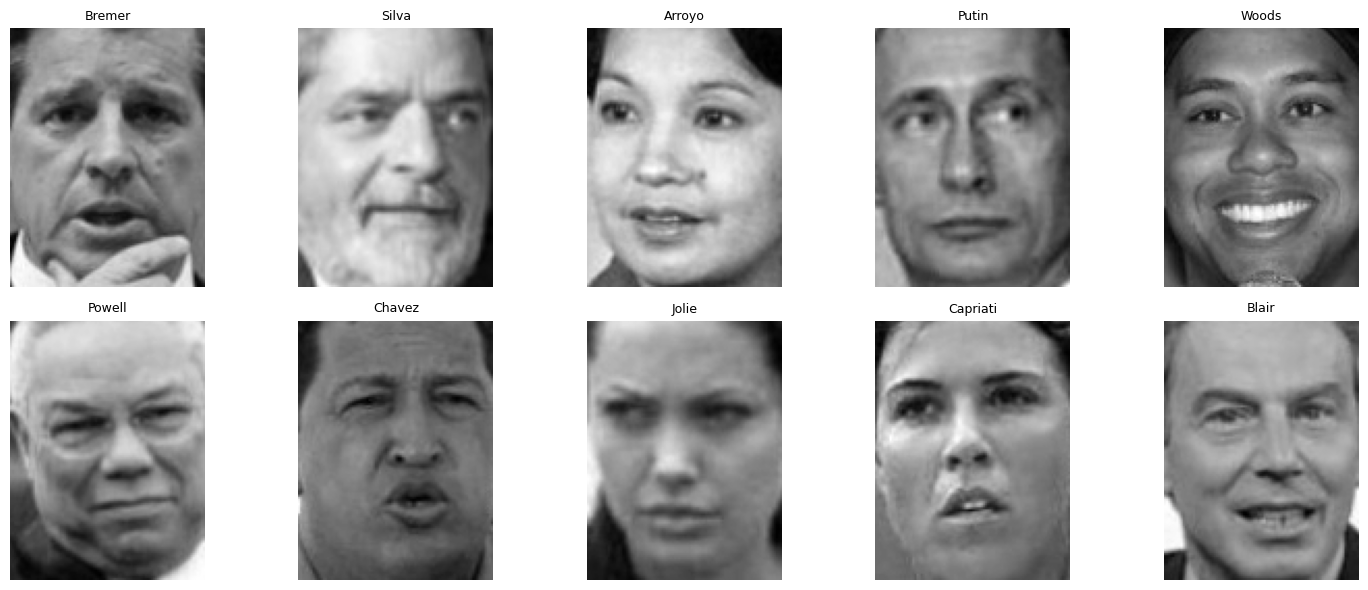

In [18]:
# Affichage des faux négatifs (visages non détectés)
if faux_negatifs:
    print("\n=== FAUX NÉGATIFS (visages non détectés) ===")
    n_show = min(10, len(faux_negatifs))
    images_fn = [fn[0] for fn in faux_negatifs[:n_show]]
    titres_fn = [target_names[y[fn[1]]].split()[-1] for fn in faux_negatifs[:n_show]]
    
    afficher_images(images_fn, titres_fn, n_cols=5, figsize=(15, 6))
else:
    print("Aucun faux négatif !")


=== FAUX POSITIFS (détections multiples) ===


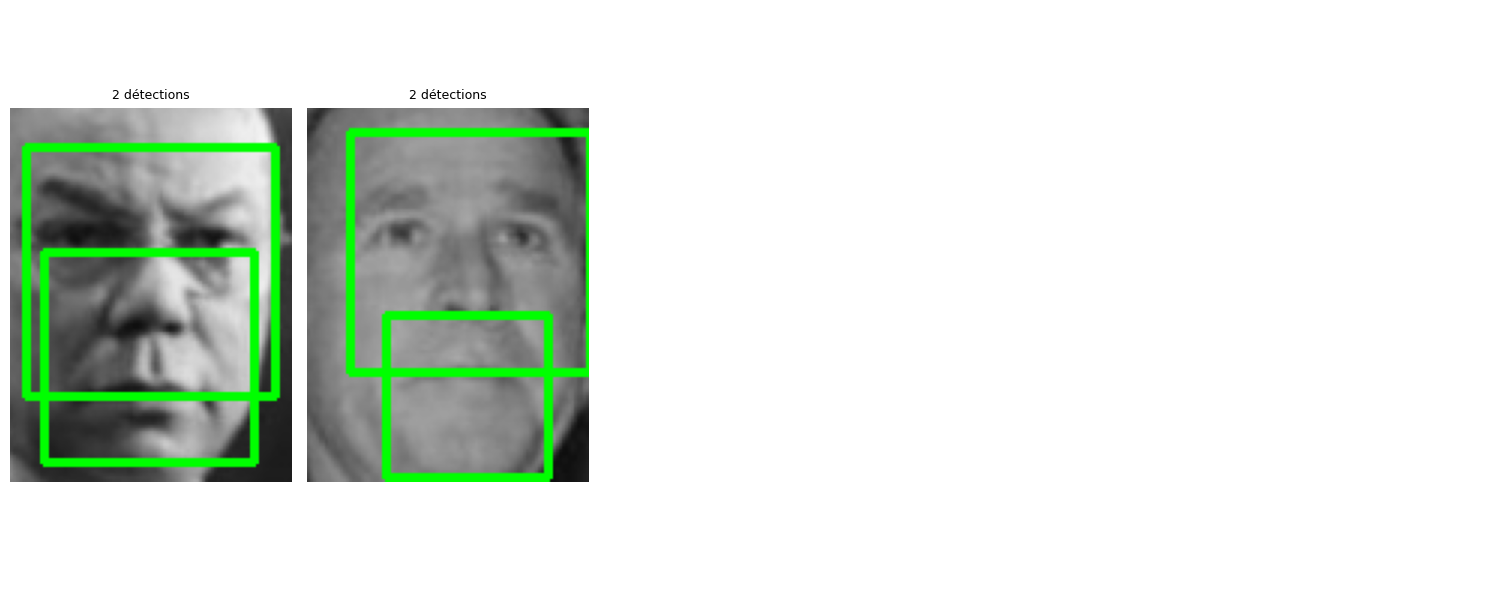

In [19]:
# Affichage des faux positifs (plusieurs détections)
if faux_positifs:
    print("\n=== FAUX POSITIFS (détections multiples) ===")
    n_show = min(10, len(faux_positifs))
    
    images_fp = []
    titres_fp = []
    for img, faces, idx in faux_positifs[:n_show]:
        img_result = dessiner_rectangles(img, faces)
        images_fp.append(img_result)
        titres_fp.append(f"{len(faces)} détections")
    
    afficher_images(images_fp, titres_fp, n_cols=5, figsize=(15, 6))
else:
    print("Aucun faux positif !")

## 7. Détection hiérarchique : Visages → Yeux

Une technique pour améliorer la fiabilité est de valider les visages détectés en cherchant les yeux à l'intérieur.

In [21]:
def detecter_visages_et_yeux(image, 
                              face_cascade=face_cascade,
                              eye_cascade=eye_cascade,
                              valider_avec_yeux=True,
                              min_yeux=1):
    """
    Détecte les visages et optionnellement valide avec les yeux.
    
    Paramètres
    ----------
    image : ndarray
        Image en niveaux de gris
    valider_avec_yeux : bool
        Si True, ne garde que les visages contenant des yeux
    min_yeux : int
        Nombre minimum d'yeux pour valider un visage
    
    Retourne
    --------
    tuple : (visages_valides, tous_yeux)
    """
    # Détection des visages
    faces = face_cascade.detectMultiScale(
        image,
        scaleFactor=1.1,
        minNeighbors=4,
        minSize=(20, 20)
    )
    
    visages_valides = []
    tous_yeux = []
    
    for (x, y, w, h) in faces:
        # Extraire la région du visage
        roi = image[y:y+h, x:x+w]
        
        # Chercher les yeux dans la moitié supérieure du visage
        roi_yeux = roi[0:h//2, :]
        
        yeux = eye_cascade.detectMultiScale(
            roi_yeux,
            scaleFactor=1.1,
            minNeighbors=3,
            minSize=(5, 5)
        )
        
        # Convertir les coordonnées des yeux en coordonnées globales
        yeux_global = [(x + ex, y + ey, ew, eh) for (ex, ey, ew, eh) in yeux]
        
        if valider_avec_yeux:
            if len(yeux) >= min_yeux:
                visages_valides.append((x, y, w, h))
                tous_yeux.extend(yeux_global)
        else:
            visages_valides.append((x, y, w, h))
            tous_yeux.extend(yeux_global)
    
    return visages_valides, tous_yeux

Vert = visages, Bleu = yeux


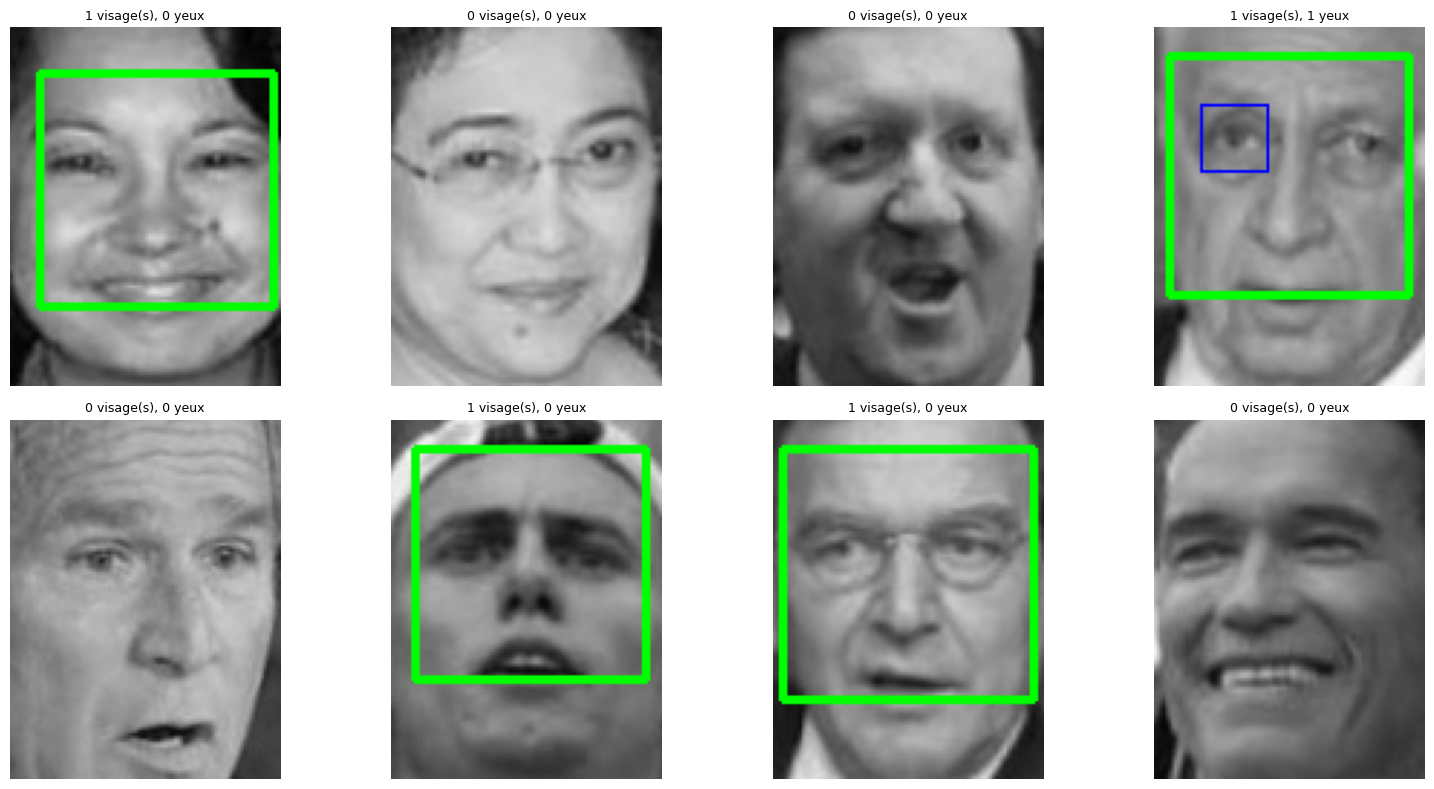

In [23]:
# Démonstration sur quelques images
np.random.seed(123)
indices_demo = np.random.choice(n_samples, 8, replace=False)

resultats_hier = []
titres_hier = []

for idx in indices_demo:
    img = X_cv[idx]
    
    # Détection hiérarchique
    visages, yeux = detecter_visages_et_yeux(img, valider_avec_yeux=False)
    
    # Dessiner les résultats
    img_result = dessiner_rectangles(img, visages, couleur=(0, 255, 0), epaisseur=2)
    img_result = dessiner_rectangles(img_result, yeux, couleur=(255, 0, 0), epaisseur=1)
    
    resultats_hier.append(img_result)
    titres_hier.append(f"{len(visages)} visage(s), {len(yeux)} yeux")

print("Vert = visages, Bleu = yeux")
afficher_images(resultats_hier, titres_hier, n_cols=4, figsize=(16, 8))

In [24]:
# Évaluation avec validation par les yeux
def evaluer_avec_validation_yeux(images, min_yeux=1):
    """
    Évalue la détection avec validation par les yeux.
    """
    stats = {
        'total': len(images),
        'tp': 0,
        'fn': 0,
        'fp': 0,
        'temps_total': 0
    }
    
    for img in images:
        start = time.perf_counter()
        visages, _ = detecter_visages_et_yeux(
            img, 
            valider_avec_yeux=True,
            min_yeux=min_yeux
        )
        stats['temps_total'] += time.perf_counter() - start
        
        n_faces = len(visages)
        if n_faces == 1:
            stats['tp'] += 1
        elif n_faces == 0:
            stats['fn'] += 1
        else:
            stats['fp'] += 1
    
    stats['taux_detection'] = stats['tp'] / stats['total'] * 100
    stats['taux_faux_negatifs'] = stats['fn'] / stats['total'] * 100
    stats['taux_faux_positifs'] = stats['fp'] / stats['total'] * 100
    stats['temps_moyen_ms'] = stats['temps_total'] / stats['total'] * 1000
    
    return stats

# Comparaison sans et avec validation par les yeux
print("Comparaison : Détection simple vs Validation par les yeux")
print("=" * 60)

stats_simple = evaluer_detecteur(X_eval, face_cascade, min_neighbors=4)
stats_yeux = evaluer_avec_validation_yeux(X_eval, min_yeux=1)

print(f"\n{'Métrique':<25} {'Simple':<15} {'Avec yeux':<15}")
print("-" * 55)
print(f"{'Taux détection':<25} {stats_simple['taux_detection']:.1f}%{'':<10} {stats_yeux['taux_detection']:.1f}%")
print(f"{'Faux négatifs':<25} {stats_simple['taux_faux_negatifs']:.1f}%{'':<10} {stats_yeux['taux_faux_negatifs']:.1f}%")
print(f"{'Faux positifs':<25} {stats_simple['taux_faux_positifs']:.1f}%{'':<10} {stats_yeux['taux_faux_positifs']:.1f}%")
print(f"{'Temps moyen (ms)':<25} {stats_simple['temps_moyen_ms']:.2f}{'':<12} {stats_yeux['temps_moyen_ms']:.2f}")

Comparaison : Détection simple vs Validation par les yeux

Métrique                  Simple          Avec yeux      
-------------------------------------------------------
Taux détection            35.6%           11.8%
Faux négatifs             64.0%           88.2%
Faux positifs             0.4%           0.0%
Temps moyen (ms)          5.92             6.57


---

## 8. Création d'images composites (plusieurs visages)

Pour tester la détection multiple, créons des images avec plusieurs visages.

In [25]:
def creer_image_groupe(images, n_cols=4, padding=10):
    """
    Crée une image composite avec plusieurs visages.
    
    Paramètres
    ----------
    images : list
        Liste d'images de visages
    n_cols : int
        Nombre de colonnes
    padding : int
        Espacement entre les images
    
    Retourne
    --------
    ndarray : Image composite
    """
    n = len(images)
    n_rows = (n + n_cols - 1) // n_cols
    
    img_h, img_w = images[0].shape[:2]
    
    # Dimensions de l'image finale
    total_h = n_rows * img_h + (n_rows + 1) * padding
    total_w = n_cols * img_w + (n_cols + 1) * padding
    
    # Fond gris
    composite = np.ones((total_h, total_w), dtype=np.uint8) * 180
    
    # Placer les images
    for i, img in enumerate(images):
        row = i // n_cols
        col = i % n_cols
        
        y = padding + row * (img_h + padding)
        x = padding + col * (img_w + padding)
        
        composite[y:y+img_h, x:x+img_w] = img
    
    return composite


# Créer quelques images de groupe
np.random.seed(456)

# Groupe de 4 personnes
indices_4 = np.random.choice(n_samples, 4, replace=False)
img_groupe_4 = creer_image_groupe([X_cv[i] for i in indices_4], n_cols=2)

# Groupe de 6 personnes
indices_6 = np.random.choice(n_samples, 6, replace=False)
img_groupe_6 = creer_image_groupe([X_cv[i] for i in indices_6], n_cols=3)

# Groupe de 9 personnes
indices_9 = np.random.choice(n_samples, 9, replace=False)
img_groupe_9 = creer_image_groupe([X_cv[i] for i in indices_9], n_cols=3)

print("Images de groupe créées")
print(f"  - Groupe 4 : {img_groupe_4.shape}")
print(f"  - Groupe 6 : {img_groupe_6.shape}")
print(f"  - Groupe 9 : {img_groupe_9.shape}")

Images de groupe créées
  - Groupe 4 : (280, 218)
  - Groupe 6 : (280, 322)
  - Groupe 9 : (415, 322)


Détection sur images de groupe :
Groupe de 4: 4/4 visages détectés ✓ (37.0 ms)
Groupe de 6: 6/6 visages détectés ✓ (56.1 ms)
Groupe de 9: 9/9 visages détectés ✓ (96.3 ms)


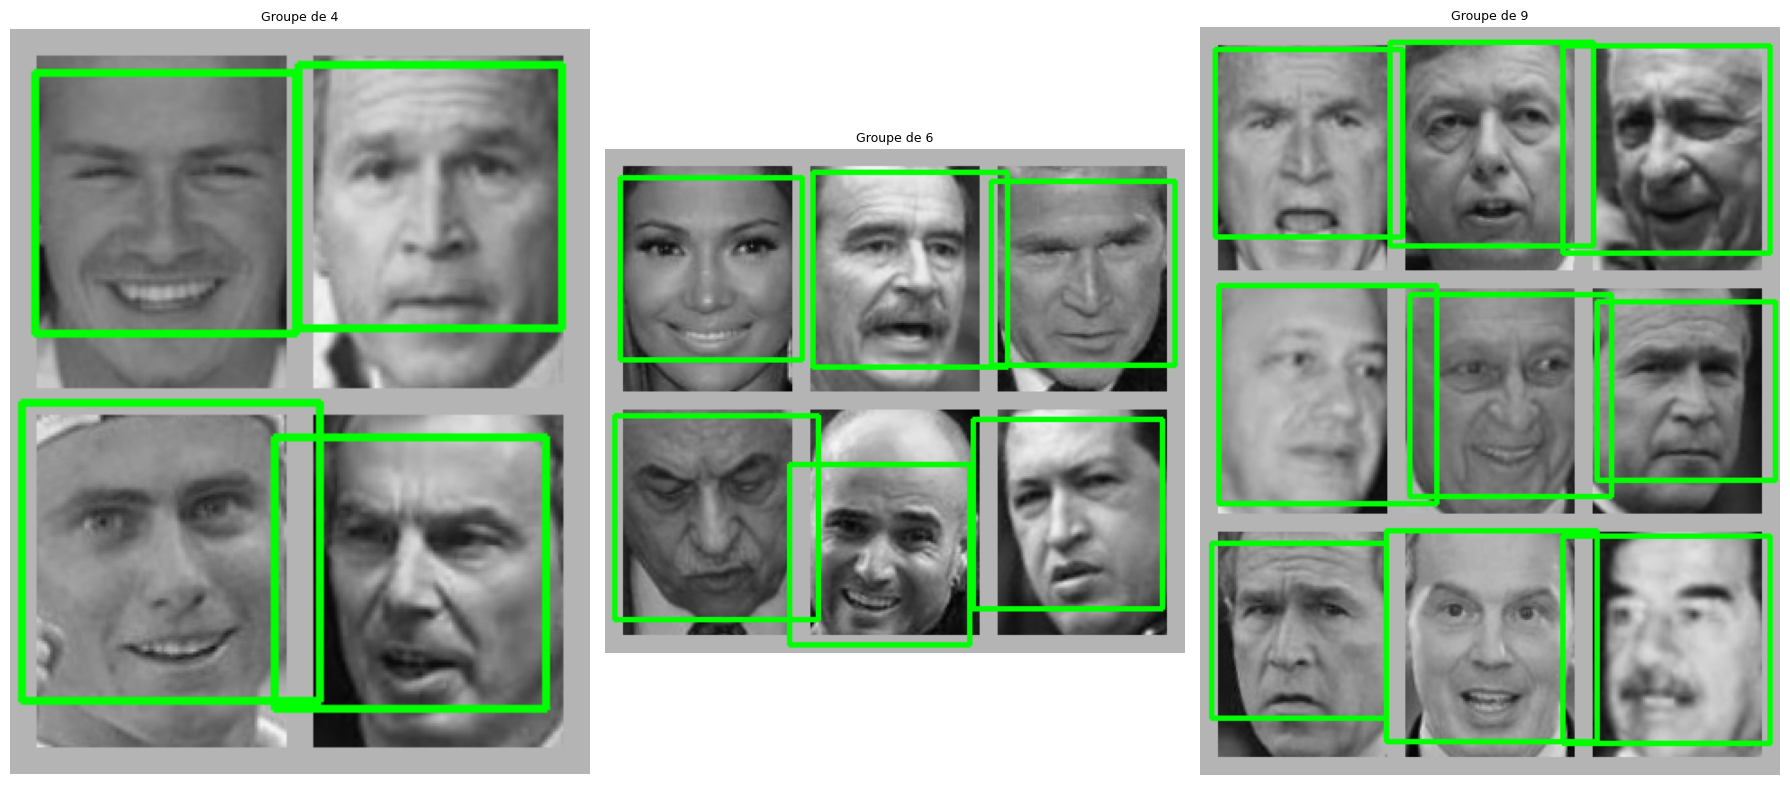

In [26]:
# Détection sur les images de groupe
def tester_detection_groupe(img_groupe, n_attendu, titre):
    """
    Teste la détection sur une image de groupe.
    """
    start = time.perf_counter()
    faces = detecter_visages(img_groupe, min_neighbors=4, min_size=(30, 30))
    elapsed = (time.perf_counter() - start) * 1000
    
    img_result = dessiner_rectangles(img_groupe, faces)
    
    n_detecte = len(faces)
    status = "✓" if n_detecte == n_attendu else "✗"
    
    print(f"{titre}: {n_detecte}/{n_attendu} visages détectés {status} ({elapsed:.1f} ms)")
    
    return img_result

print("Détection sur images de groupe :")
print("=" * 50)

result_4 = tester_detection_groupe(img_groupe_4, 4, "Groupe de 4")
result_6 = tester_detection_groupe(img_groupe_6, 6, "Groupe de 6")
result_9 = tester_detection_groupe(img_groupe_9, 9, "Groupe de 9")

afficher_images(
    [result_4, result_6, result_9],
    ['Groupe de 4', 'Groupe de 6', 'Groupe de 9'],
    n_cols=3,
    figsize=(18, 8)
)

## 9. Exercices pratiques

### Exercice 1 : Optimisation des paramètres

**Objectif** : Trouver la meilleure combinaison de paramètres pour maximiser le taux de détection tout en minimisant les faux positifs.

In [ ]:
# TODO : Testez différentes combinaisons de paramètres
# 
# Paramètres à explorer :
# - scaleFactor : [1.05, 1.1, 1.15, 1.2]
# - minNeighbors : [2, 3, 4, 5, 6]
# - minSize : [(10,10), (15,15), (20,20), (30,30)]
#
# Créez un tableau récapitulatif des résultats
# Identifiez la meilleure combinaison

# Votre code ici :
# ...

### Exercice 2 : Pipeline complet de détection

**Objectif** : Créer une fonction complète qui :
1. Charge une image
2. Détecte les visages
3. Pour chaque visage, détecte les yeux
4. Extrait et sauvegarde chaque visage détecté
5. Retourne des statistiques

In [ ]:
def pipeline_detection_complet(image):
    """
    Pipeline complet de détection de visages.
    
    Paramètres
    ----------
    image : ndarray
        Image en niveaux de gris
    
    Retourne
    --------
    dict : Résultats de la détection
        - 'image_annotee' : Image avec rectangles
        - 'visages' : Liste des régions de visages extraites
        - 'n_visages' : Nombre de visages
        - 'n_yeux' : Nombre total d'yeux
        - 'temps_ms' : Temps de traitement
    """
    # TODO : Implémentez le pipeline
    #
    # Étapes :
    # 1. Détecter les visages
    # 2. Pour chaque visage, détecter les yeux
    # 3. Extraire les ROI des visages
    # 4. Annoter l'image
    # 5. Retourner les résultats
    
    pass  # Remplacez par votre code


# Test du pipeline
# result = pipeline_detection_complet(img_groupe_6)
# print(f"Visages détectés : {result['n_visages']}")
# print(f"Yeux détectés : {result['n_yeux']}")
# print(f"Temps : {result['temps_ms']:.2f} ms")

### Exercice 3 : Analyse des performances par personne

**Objectif** : Analyser si certaines personnes sont mieux détectées que d'autres.

In [ ]:
# TODO : Pour chaque personne du dataset :
# 1. Calculer le taux de détection
# 2. Identifier les personnes les mieux/moins bien détectées
# 3. Analyser visuellement pourquoi certains visages sont difficiles
#    (éclairage, angle, expression, lunettes...)

# Votre code ici :
# ...

### Exercice 4 : Robustesse aux transformations

**Objectif** : Tester la robustesse du détecteur face aux variations.

In [ ]:
def tester_robustesse(image):
    """
    Teste la détection sur différentes transformations de l'image.
    """
    transformations = {}
    
    # Image originale
    transformations['Originale'] = image
    
    # TODO : Ajoutez des transformations :
    # - Rotation (cv2.rotate)
    # - Changement d'échelle (cv2.resize)
    # - Modification de luminosité
    # - Ajout de bruit
    # - Flou
    
    # Votre code ici :
    # transformations['Rotation 90°'] = ...
    # transformations['Échelle 50%'] = ...
    # etc.
    
    return transformations

# Test
# idx_test = np.random.randint(0, n_samples)
# transforms = tester_robustesse(X_cv[idx_test])
# 
# for nom, img_t in transforms.items():
#     faces = detecter_visages(img_t)
#     print(f"{nom}: {len(faces)} visage(s) détecté(s)")

## 10. Résumé et conclusions

### Ce que nous avons appris

1. **Principe des Haar Cascades** : Caractéristiques de Haar + AdaBoost + Cascade de classifieurs

2. **Utilisation pratique** :
   - `cv2.CascadeClassifier()` pour charger un classifieur
   - `detectMultiScale()` pour la détection
   - Paramètres clés : `scaleFactor`, `minNeighbors`, `minSize`

3. **Détection hiérarchique** : Valider les visages en détectant les yeux

4. **Évaluation** : Vrais positifs, faux positifs, faux négatifs

### Limitations des Haar Cascades

- Sensibles à l'orientation (visages de profil mal détectés)
- Faux positifs sur des textures similaires aux visages
- Moins précis que les méthodes deep learning (MTCNN, RetinaFace...)

### Quand utiliser Haar Cascades ?

- Applications temps réel sur CPU
- Ressources limitées (embarqué)
- Détection de visages frontaux dans des conditions contrôlées
- Prototypage rapide

### Alternatives modernes (pour  aller plus loin): 
  - dlib (HOG + SVM)
  - MTCNN (deep learning)
  - RetinaFace (deep learning)